# Structured Streaming Basics
Structured Streaming, as we discussed at the end of Chapter 20, is a stream processing
framework built on the Spark SQL engine. Rather than introducing a separate API, Structured
Streaming uses the existing structured APIs in Spark (DataFrames, Datasets, and SQL), meaning
that all the operations you are familiar with there are supported. Users express a streaming
computation in the same way they’d write a batch computation on static data. Upon specifying
this, and specifying a streaming destination, the Structured Streaming engine will take care of
running your query incrementally and continuously as new data arrives into the system.

## Input Sources
Structured Streaming supports several input sources for reading in a streaming fashion. As of
Spark 2.2, the supported input sources are as follows:
1. Apache Kafka 0.10
2. Files on a distributed file system like HDFS or S3 (Spark will continuously read new
files in a directory)
3. A socket source for testing

## Sinks
Just as sources allow you to get data into Structured Streaming, sinks specify the destination for
the result set of that stream. Sinks and the execution engine are also responsible for reliably
tracking the exact progress of data processing. Here are the supported output sinks as of Spark 2.2:
1. Apache Kafka 0.10
2. Almost any file format
3. A foreach sink for running arbitary computation on the output records
4. A console sink for testing
5. A memory sink for debugging

## Output Modes
Defining a sink for our Structured Streaming job is only half of the story. We also need to define
how we want Spark to write data to that sink. For instance, do we only want to append new
information? Do we want to update rows as we receive more information about them over time
(e.g., updating the click count for a given web page)? Do we want to completely overwrite the
result set every single time (i.e. always write a file with the complete click counts for all pages)?

To do this, we define an output mode, similar to how we define output modes in the static
Structured APIs.
The supported output modes are as follows:
1. Append (only add new records to the output sink)
2. Update (update changed records in place)
3. Complete (rewrite the full output)

One important detail is that certain queries, and certain sinks, only support certain output modes,
as we will discuss later in the book. For example, suppose that your job is just performing a map
on a stream. The output data will grow indefinitely as new records arrive, so it would not make
sense to use Complete mode, which requires writing all the data to a new file at once. In contrast,
if you are doing an aggregation into a limited number of keys, Complete and Update modes
would make sense, but Append would not, because the values of some keys’ need to be updated
over time.

## Triggers
Whereas output modes define how data is output, triggers define when data is output—that is,
when Structured Streaming should check for new input data and update its result. By default,
Structured Streaming will look for new input records as soon as it has finished processing the last
group of input data, giving the lowest latency possible for new results. However, this behavior
can lead to writing many small output files when the sink is a set of files. Thus, Spark also
supports triggers based on processing time (only look for new data at a fixed interval). In the
future, other types of triggers may also be supported.

### Event-Time Processing
Structured Streaming also has support for event-time processing (i.e., processing data based on
timestamps included in the record that may arrive out of order). There are two key ideas that you
will need to understand here for the moment; we will talk about both of these in much more
depth in the next chapter, so don’t worry if you’re not perfectly clear on them at this point.

#### Watermarks
Watermarks are a feature of streaming systems that allow you to specify how late they expect to
see data in event time. For example, in an application that processes logs from mobile devices,
one might expect logs to be up to 30 minutes late due to upload delays.

# Structured Streaming in Action
Let’s get to an applied example of how you might use Structured Streaming. For our examples,
we’re going to be working with the Heterogeneity Human Activity Recognition Dataset. The
data consists of smartphone and smartwatch sensor readings from a variety of devices—
specifically, the accelerometer and gyroscope, sampled at the highest possible frequency
supported by the devices. Readings from these sensors were recorded while users performed
activities like biking, sitting, standing, walking, and so on. There are several different
smartphones and smartwatches used, and nine total users.

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
static = spark.read.json("../data/activity-data/")
dataSchema = static.schema

In [3]:
static.printSchema()

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [4]:
static.show(4)

+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|           y|           z|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
|1424686735090|1424686733090638193|nexus4_1|   18|nexus4|   g|stand| 3.356934E-4|-5.645752E-4|-0.018814087|
|1424686735292|1424688581345918092|nexus4_2|   66|nexus4|   g|stand|-0.005722046| 0.029083252| 0.005569458|
|1424686735500|1424686733498505625|nexus4_1|   99|nexus4|   g|stand|   0.0078125|-0.017654419| 0.010025024|
|1424686735691|1424688581745026978|nexus4_2|  145|nexus4|   g|stand|-3.814697E-4|   0.0184021|-0.013656616|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
only showing top 4 rows



Next, let’s create a streaming version of the same Dataset, which will read each input file in the
dataset one by one as if it was a stream.
Streaming DataFrames are largely the same as static DataFrames.

However, one small difference is that Structured Streaming does not let
you perform schema inference without explicitly enabling it. You can enable schema inference
for this by setting the configuration spark.sql.streaming.schemaInference to true. Given
that fact, we will read the schema from one file (that we know has a valid schema) and pass the
dataSchema object from our static DataFrame to our streaming DataFrame. As mentioned, you
should avoid doing this in a production scenario where your data may (accidentally) change out
from under you:

In [5]:
streaming = spark.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1)\
.json("../data/activity-data")

Just like with other Spark APIs, streaming DataFrame creation and execution is lazy. In
particular, we can now specify transformations on our streaming DataFrame before finally
calling an action to start the stream. In this case, we’ll show one simple transformation—we will
group and count data by the gt column, which is the activity being performed by the user at that
point in time:

In [6]:
activityCounts = streaming.groupBy("gt").count()

Because this code is being written in local mode on a small machine, we are going to set the
shuffle partitions to a small value to avoid creating too many shuffle partitions:

In [7]:
spark.conf.set("spark.sql.shuffle.partitions", 5)

Now that we set up our transformation, we need only to specify our action to start the query. As
mentioned previously in the chapter, we will specify an output destination, or output sink for our
result of this query. For this basic example, we are going to write to a memory sink which keeps
an in-memory table of the results.

In the process of specifying this sink, we’re going to need to define how Spark will output that
data. In this example, we use the complete output mode. This mode rewrites all of the keys along
with their counts after every trigger:

In [8]:
activityQuery = activityCounts.writeStream.queryName("activity_counts")\
.format("memory").outputMode("complete")\
.start()

We are now writing out our stream! You’ll notice that we set a unique query name to represent
this stream, in this case activity_counts. We specified our format as an in-memory table and
we set the output mode.

When we run the preceding code, we also want to include the following line:

In [ ]:
activityQuery.awaitTermination()

After this code is executed, the streaming computation will have started in the background. The
query object is a handle to that active streaming query, and we must specify that we would like
to wait for the termination of the query using activityQuery.awaitTermination() to prevent
the driver process from exiting while the query is active. We will omit this from our future parts
of the book for readability, but it must be included in your production applications; otherwise,
your stream won’t be able to run.

Spark lists this stream, and other active ones, under the active streams in our SparkSession. We
can see a list of those streams by running the following:

In [10]:
list(spark.streams.active)

In [12]:
from time import sleep
for x in range(5):
    spark.sql("SELECT * FROM activity_counts").show()
    sleep(1)

+----------+------+
|        gt| count|
+----------+------+
|       sit|824697|
|     stand|762780|
|stairsdown|627335|
|      walk|888088|
|  stairsup|700645|
|      null|699922|
|      bike|723360|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|849316|
|     stand|785548|
|stairsdown|646057|
|      walk|914597|
|  stairsup|721567|
|      null|720815|
|      bike|744953|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|861627|
|     stand|796934|
|stairsdown|655422|
|      walk|927850|
|  stairsup|732025|
|      null|731260|
|      bike|755747|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|886249|
|     stand|819705|
|stairsdown|674153|
|      walk|954358|
|  stairsup|752939|
|      null|752149|
|      bike|777337|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|898556|
|     stand|831090|
|stairsdown|6835

# Transformations on Streams
Streaming transformations, as we mentioned, include almost all static DataFrame
transformations that you already saw in Part II. All select, filter, and simple transformations are
supported, as are all DataFrame functions and individual column manipulations. The limitations
arise on transformations that do not make sense in context of streaming data. For example, as of
Apache Spark 2.2, users cannot sort streams that are not aggregated, and cannot perform
multiple levels of aggregation without using Stateful Processing (covered in the next chater).
These limitations may be lifted as Structured Streaming continues to develop, so we encourage
you to check the documentation of your version of Spark for updates.

## Selections and Filtering
All select and filter transformations are supported in Structured Streaming, as are all DataFrame
functions and individual column manipulations. We show a simple example using selections and
filtering below. In this case, because we are not updating any keys over time, we will use the
Append output mode, so that new results are appended to the output table:

In [13]:
from pyspark.sql.functions import expr
simpleTransform = streaming.withColumn("stairs", expr("gt like '%stairs%'"))\
.where("stairs")\
.where("gt is not null")\
.select("gt", "model", "arrival_time", "creation_time")\
.writeStream\
.queryName("simple_transform")\
.format("memory")\
.outputMode("append")\
.start()

## Aggregations
Structured Streaming has excellent support for aggregations. You can specify arbitrary
aggregations, as you saw in the Structured APIs. For example, you can use a more exotic
aggregation, like a cube, on the phone model and activity and the average x, y, z accelerations of
our sensor (jump back to Chapter 7 in order to see potential aggregations that you can run on
your stream):

In [14]:
deviceModelStats = streaming.cube("gt", "model").avg()\
.drop("avg(Arrival_time)")\
.drop("avg(Creation_Time)")\
.drop("avg(Index)")\
.writeStream.queryName("device_counts").format("memory")\
.outputMode("complete")\
.start()

In [18]:
spark.sql('SELECT * FROM device_counts').show()

+----------+------+--------------------+--------------------+--------------------+
|        gt| model|              avg(x)|              avg(y)|              avg(z)|
+----------+------+--------------------+--------------------+--------------------+
|       sit|  null|-6.31601144100526...|1.898805381022023...|-1.87792168310448...|
|     stand|  null|-4.37317949751123...|1.750967655003801...|3.781399850939871...|
|       sit|nexus4|-6.31601144100526...|1.898805381022023...|-1.87792168310448...|
|     stand|nexus4|-4.37317949751123...|1.750967655003801...|3.781399850939871...|
|      null|  null|-0.00982687243854...|-2.34653177343797...|0.003858852205067...|
|      null|  null|3.918533547417218E-4|-0.00542182729197...|-0.00965178445029...|
|      walk|  null|-0.00474912305724...|0.004750564660523073|-5.96844509898165E-4|
|      null|nexus4|-0.00982687243854...|-2.34653177343797...|0.003858852205067...|
|      null|nexus4|3.918533547417218E-4|-0.00542182729197...|-0.00965178445029...|
|   

In addition to these aggregations on raw columns in the dataset, Structured Streaming has special
support for columns that represent event time, including watermark support and windowing. We
will discuss these in more detail in Chapter 22.

## Joins
As of Apache Spark 2.2, Structured Streaming supports joining streaming DataFrames to static
DataFrames. Spark 2.3 will add the ability to join multiple streams together. You can do multiple
column joins and supplement streaming data with that from static data sources:

In [20]:
historicalAgg = static.groupBy("gt", "model").avg()
deviceModelStats = streaming.drop("Arrival_Time", "Creation_Time", "Index")\
.cube("gt", "model").avg()\
.join(historicalAgg, ["gt", "model"])\
.writeStream.queryName("device_counts_1").format("memory")\
.outputMode("complete")\
.start()

In Spark 2.2, full outer joins, left joins with the stream on the right side, and right joins with the
stream on the left are not supported. Structured Streaming also does not yet support stream-tostream
joins, but this is also a feature under active development.
# Input and Output
This section dives deeper into the details of how sources, sinks, and output modes work in
Structured Streaming. Specifically, we discuss how, when, and where data flows into and out of
the system.
## File source and sink
Probably the simplest source you can think of is the simple file source. It’s easy to reason about
and understand. While essentially any file source should work, the ones that we see in practice
are Parquet, text, JSON, and CSV.

The only difference between using the file source/sink and Spark’s static file source is that with
streaming, we can control the number of files that we read in during each trigger via the
maxFilesPerTrigger option that we saw earlier.

Keep in mind that any files you add into an input directory for a streaming job need to appear in
it atomically. Otherwise, Spark will process partially written files before you have finished. On
file systems that show partial writes, such as local files or HDFS, this is best done by writing the
file in an external directory and moving it into the input directory when finished. On Amazon S3,
objects normally only appear once fully written.

## Kafka source and sink
Apache Kafka is a distributed publish-and-subscribe system for streams of data. Kafka lets you
publish and subscribe to streams of records like you might do with a message queue—these are
stored as streams of records in a fault-tolerant way. Think of Kafka like a distributed buffer.

Kafka lets you store streams of records in categories that are referred to as topics. Each record in
Kafka consists of a key, a value, and a timestamp. Topics consist of immutable sequences of
records for which the position of a record in a sequence is called an offset. Reading data is called
subscribing to a topic and writing data is as simple as publishing to a topic.
Spark allows you to read from Kafka with both batch and streaming DataFrames.

To read from Kafka, do the following in Structured Streaming:

In [ ]:
# Subscribe to 1 topic
df1 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribe", "topic1")\
.load()
# Subscribe to multiple topics
df2 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribe", "topic1,topic2")\
.load()
# Subscribe to a pattern
df3 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribePattern", "topic.*")\
.load()

Each row in the source will have the following schema:
1. key: binary
2. value: binary
3. topic: string
4. partition: int
5. offset: long
6. timestamp: long

Each message in Kafka is likely to be serialized in some way. Using native Spark functions in
the Structured APIs, or a User-Defined Function (UDF), you can parse the message into a more
structured format analysis. A common pattern is to use JSON or Avro to read and write to Kafka.

## Writing to the Kafka Sink
Writing to Kafka queries is largely the same as reading from them except for fewer parameters.
You’ll still need to specify the Kafka bootstrap servers, but the only other option you will need to
supply is either a column with the topic specification or supply that as an option. For example,
the following writes are equivalent:

In [ ]:
df1.selectExpr("topic", "CAST(key AS STRING)", "CAST(value AS STRING)")\
.writeStream\
.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("checkpointLocation", "/to/HDFS-compatible/dir")\
.start()
df1.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")\
.writeStream\
.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("checkpointLocation", "/to/HDFS-compatible/dir")\
.option("topic", "topic1")\
.start()

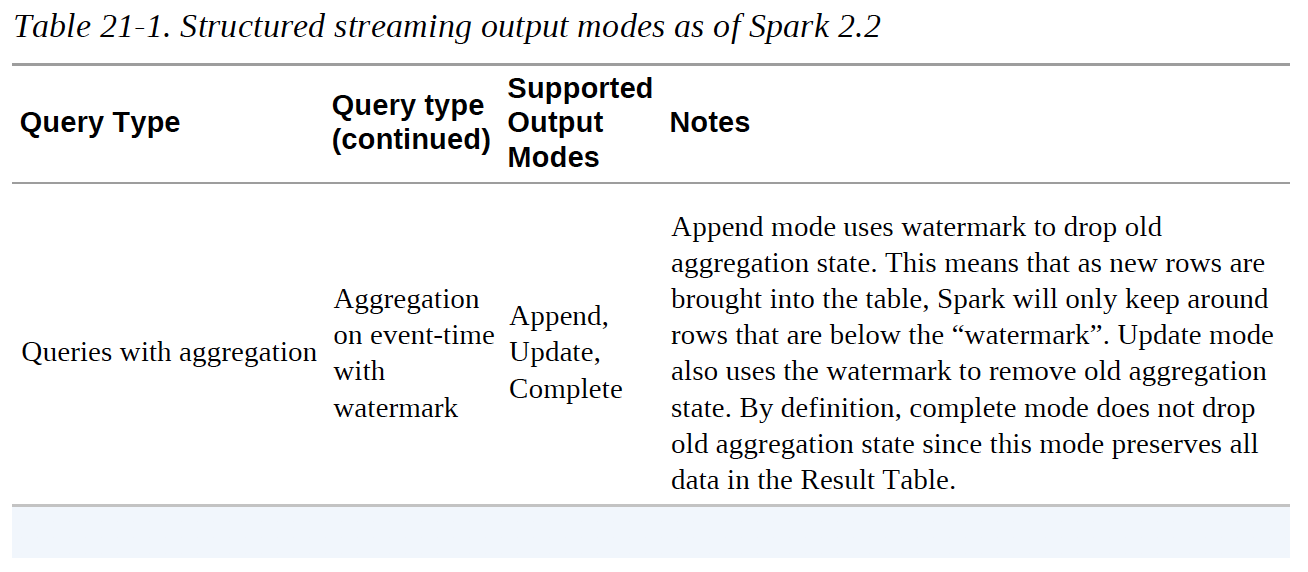
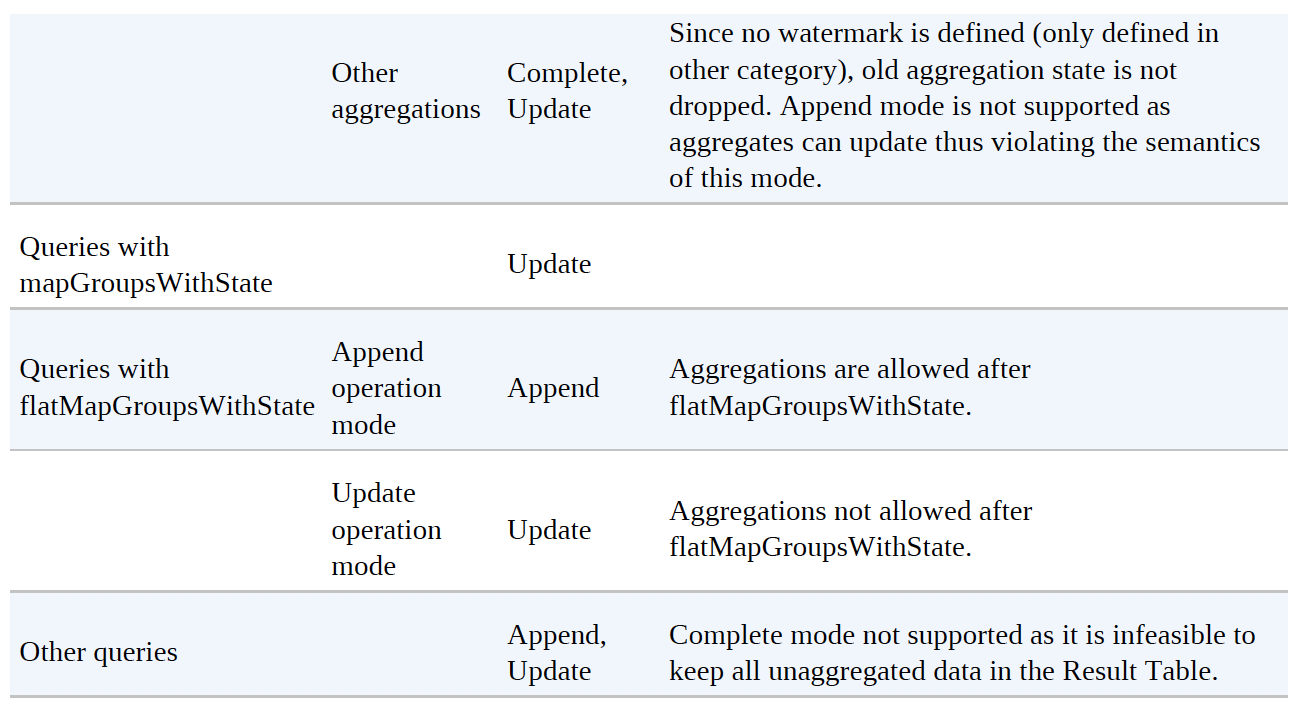

## When Data Is Output (Triggers)
To control when data is output to our sink, we set a trigger. By default, Structured Streaming
will start data as soon as the previous trigger completes processing. You can use triggers to
ensure that you do not overwhelm your output sink with too many updates or to try and control
file sizes in the output. Currently, there is one periodic trigger type, based on processing time, as
well as a “once” trigger to manually run a processing step once. More triggers will likely be
added in the future.
### Processing time trigger
For the processing time trigger, we simply specify a duration as a string (you may also use a
Duration in Scala or TimeUnit in Java). We’ll show the string format below.

In [ ]:
activityCounts.writeStream.trigger(processingTime='5 seconds')\
.format("console").outputMode("complete").start()

The ProcessingTime trigger will wait for multiples of the given duration in order to output data.
For example, with a trigger duration of one minute, the trigger will fire at 12:00, 12:01, 12:02,
and so on. If a trigger time is missed because the previous processing has not yet completed, then
Spark will wait until the next trigger point (i.e., the next minute), rather than firing immediately
after the previous processing completes.

### Once trigger
You can also just run a streaming job once by setting that as the trigger. This might seem like a
weird case, but it’s actually extremely useful in both development and production. During
development, you can test your application on just one trigger’s worth of data at a time. During
production, the Once trigger can be used to run your job manually at a low rate (e.g., import new
data into a summary table just occasionally). Because Structured Streaming still fully tracks all
the input files processed and the state of the computation, this is easier than writing your own
custom logic to track this in a batch job, and saves a lot of resources over running a continuous
job 24/7:

In [ ]:
activityCounts.writeStream.trigger(once=True)\
.format("console").outputMode("complete").start()

# Conclusion
It should be clear that Structured Streaming presents a powerful way to write streaming
applications. Taking a batch job you already run and turning it into a streaming job with almost
no code changes is both simple and extremely helpful from an engineering standpoint if you
need to have this job interact closely with the rest of your data processing application.
Chapter 22 dives into two advanced streaming-related concepts: event-time processing and
stateful processing. Then, after that, Chapter 23 addresses what you need to do to run Structured
Streaming in production.